In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM ,Dropout
from keras.callbacks import EarlyStopping
from keras import layers

from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


----------------------

#### 1. 환율

In [2]:
rate=pd.read_csv('data/USD_KRW.csv')
rate.columns=['date', 'rate']
rate=rate.set_index('date')
rate_train=rate.loc['2018-02-01': '2019-02-01' ]
rate_test=rate.loc['2019-02-01':'2019-12-31']

#### 2. 한국 libor

In [3]:
kolib=pd.read_csv('data/KORIBOR.csv')
kolib=kolib[['date', '6month']]
kolib.columns=['date','krlibor']
kolib=kolib.set_index('date')
kolib_train=kolib.loc['2018-02-01': '2019-02-01' ]
kolib_test=kolib.loc['2019-02-01':'2019-12-31']

#### 3. 미국 libor

In [4]:
uslib=pd.read_csv('data/libor.csv')
uslib.columns=['date','uslibor']
uslib=uslib.set_index('date')

In [5]:
# 데이터에 일부분에 . 이 존재함. 
# 국가 공휴일은 삭제하고 필요한 값은 평균을 활용
del uslib['uslibor']['2018-12-25']
del uslib['uslibor']['2019-01-01']
del uslib['uslibor']['2019-05-27']
del uslib['uslibor']['2019-12-25']
del uslib['uslibor']['2020-01-01']

In [6]:
uslib['uslibor'].loc['2018-03-30'] = (float(uslib['uslibor'].loc['2018-03-29']) * 2/3 
                                            + float(uslib['uslibor'].loc['2018-04-03']) * 1/3)

uslib['uslibor'].loc['2018-04-02'] = (float(uslib['uslibor'].loc['2018-03-29']) * 1/3 
                                            + float(uslib['uslibor'].loc['2018-04-03']) * 2/3)

uslib['uslibor'].loc['2018-05-07'] = (float(uslib['uslibor'].loc['2018-05-04']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-05-08']) * 1/2)

uslib['uslibor'].loc['2018-05-28'] = (float(uslib['uslibor'].loc['2018-05-25']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-05-29']) * 1/2)

uslib['uslibor'].loc['2018-08-27'] = (float(uslib['uslibor'].loc['2018-08-24']) * 1/2 
                                            + float(uslib['uslibor'].loc['2018-08-28']) * 1/2)

uslib['uslibor'].loc['2018-12-26'] = (float(uslib['uslibor'].loc['2018-12-24']) * 2/3 
                                            + float(uslib['uslibor'].loc['2018-12-27']) * 1/3)

uslib['uslibor'].loc['2019-04-19'] = (float(uslib['uslibor'].loc['2019-04-23']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-04-18']) * 1/3)

uslib['uslibor'].loc['2019-04-22'] = (float(uslib['uslibor'].loc['2019-04-18']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-04-23']) * 1/3)

uslib['uslibor'].loc['2019-05-06'] = (float(uslib['uslibor'].loc['2019-05-03']) * 1/2
                                            + float(uslib['uslibor'].loc['2019-05-07']) * 1/2)

uslib['uslibor'].loc['2019-08-26'] = (float(uslib['uslibor'].loc['2019-08-23']) * 1/2
                                            + float(uslib['uslibor'].loc['2019-08-27']) * 1/2)

uslib['uslibor'].loc['2019-12-26'] = (float(uslib['uslibor'].loc['2019-12-24']) * 2/3 
                                            + float(uslib['uslibor'].loc['2019-12-27']) * 1/3)

In [7]:
# 값이 문자형으로 되어있어서 실수형으로 변경
uslib['uslibor']=uslib['uslibor'].apply(pd.to_numeric)

In [8]:
uslib_train=uslib.loc['2018-02-01': '2019-02-01' ]
uslib_test=uslib.loc['2019-02-01':'2019-12-31']

#### 4.s&p 500

In [9]:
snp500=pd.read_csv('data/S&P500.csv')
snp500 = snp500[::-1]
snp500=snp500[['날짜','종가']]
snp500.columns=['date','snp500']


snp500_date=[]
for i in snp500['date']:
    snp500_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

snp500_price=[]
for i in snp500['snp500']:
    i=i.replace(',','')
    snp500_price.append(np.float(i))

snp500['date']=snp500_date
snp500['snp500']=snp500_price
snp500=snp500.set_index('date')

In [10]:
snp500_train=snp500.loc['2018-02-01': '2019-02-01' ]
snp500_test=snp500.loc['2019-02-01':'2019-12-31']

#### 5. kospi200

In [11]:
kospi200=pd.read_csv('data/KOSPI200.csv')
kospi200=kospi200[['날짜','종가']]
kospi200.columns=['date','kospi200']
kospi200 = kospi200[::-1]

kospi_date=[]
for i in kospi200['date']:
    kospi_date.append(i.replace('년 ','-').replace('월 ','-').replace('일',''))

kospi200['date']=kospi_date
kospi200=kospi200.set_index('date')

In [12]:
kospi200_train=kospi200.loc['2018-02-01': '2019-02-01' ]
kospi200_test=kospi200.loc['2019-02-01':'2019-12-31']

------------------

### 정리한 데이터를 활용하여 같은 날로 묶어서 하나의 dataframe 생성

In [13]:
data_train=pd.concat([rate_train,kolib_train,uslib_train,snp500_train,kospi200_train], 
                       axis=1,  join = 'inner', sort=False)
data_test=pd.concat([rate_test,kolib_test,uslib_test,snp500_test,kospi200_test], 
                      axis=1,  join = 'inner', sort=False)

#### 데이터 프레임 정리하기

In [14]:
data_train['y']=data_train['rate'].shift(-1)
data_test['y']=data_test['rate'].shift(-1)

In [15]:
#Nan 값을 계속 찾아서 업데이트 할 예정
data_train['y'][-1]=rate_test.iloc[0]
data_train=data_train[['krlibor','uslibor','snp500','kospi200','y']]

data_test['y'][-1]=rate_test.iloc[0]
data_test=data_test[['krlibor','uslibor','snp500','kospi200','y']]
data_test=data_test[:-1]

In [16]:
train_input = data_train[['krlibor','uslibor','snp500','kospi200']]
train_target = data_train['y']
test_input = data_test[['krlibor','uslibor','snp500','kospi200']]
test_target = data_test['y']

#### scale맞추기

In [17]:
mean = train_input.mean(axis=0)
std = train_input.std(axis=0)
train_input -= mean
train_input /= std
test_input -= mean
test_input /= std

In [18]:
train_input=np.array(train_input)
train_input=train_input.reshape(train_input.shape[0],4)

#### 모델 작성하기 (DNN)

In [19]:
early_stopping = EarlyStopping(patience=50)

In [20]:
model = Sequential()

model.add(layers.Dense(units=2048, input_shape=(4,)))
model.add(Dropout(0.2))

model.add(layers.Dense(units=1024))
model.add(Dropout(0.2))

model.add(layers.Dense(units=512))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='Adagrad', loss='mean_squared_error')

In [21]:
history = model.fit(train_input, train_target, epochs=1000, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

Train on 165 samples, validate on 72 samples
Epoch 1/1000
165/165 [==============================] - 1s 3ms/step - loss: 962012.6840 - val_loss: 6687511.3333
Epoch 2/1000
165/165 [==============================] - 0s 152us/step - loss: 218681.6968 - val_loss: 5125919.8333
Epoch 3/1000
165/165 [==============================] - 0s 166us/step - loss: 146039.9002 - val_loss: 4252524.1806
Epoch 4/1000
165/165 [==============================] - 0s 162us/step - loss: 89976.8788 - val_loss: 2093124.0625
Epoch 5/1000
165/165 [==============================] - 0s 148us/step - loss: 75576.5602 - val_loss: 524880.7153
Epoch 6/1000
165/165 [==============================] - 0s 150us/step - loss: 21357.9452 - val_loss: 215812.7982
Epoch 7/1000
165/165 [==============================] - 0s 165us/step - loss: 13250.5686 - val_loss: 113035.6981
Epoch 8/1000
165/165 [==============================] - 0s 153us/step - loss: 11193.3580 - val_loss: 269025.3368
Epoch 9/1000
165/165 [========================

#### loss값 그래프로 표현

In [22]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

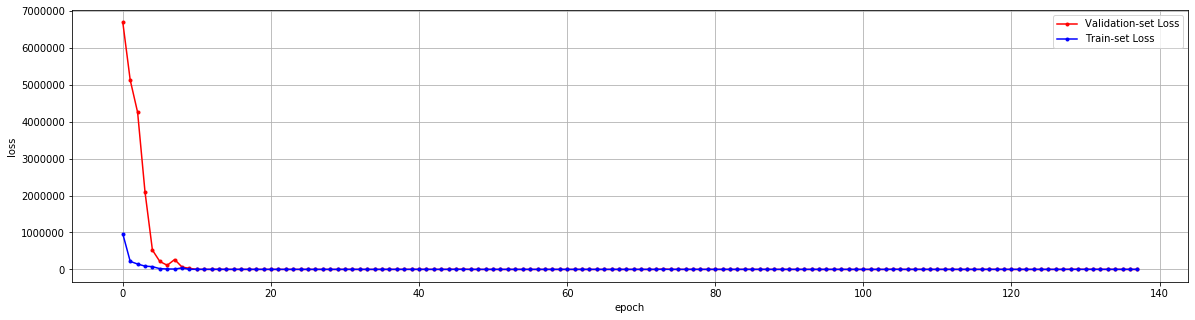

In [23]:
x_len = np.arange(len(y_loss))

plt.figure(figsize=(20,5))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### 예측하고 평가

In [24]:
predicted = model.predict(test_input)
actual=data_test['y']

RMSE = mean_squared_error(actual, predicted)**0.5    
RMSE

23.123104327146663

#### 실제값 예측값 dataframe 만들기

In [25]:
predicted = sum(predicted.tolist(), [])
actual=actual.tolist()

final=pd.DataFrame([predicted, actual]).T
final.columns=['pred','actual']
final=final.set_index(data_test.index)

#### 상승, 하락 표시

In [26]:
#train set의 마지막 데이터
lastday=rate_train[-1:]['rate']

In [27]:
actual_updown=[]
pred_updown=[]

if final['actual'][0] > lastday[0]:
    actual_updown.append('up')
else :
    actual_updown.append('down')
    
if final['pred'][0] > lastday[0]:
    pred_updown.append('up')
else :
    pred_updown.append('down')


for i in range(len(final)-1):
    
    if final['actual'][i+1] > final['actual'][i]:
        actual_updown.append('up')
    else :
        actual_updown.append('down')
        
for i in range(len(final)-1):
    
    if final['pred'][i+1] > final['actual'][i]:
        pred_updown.append('up')
    else :
        pred_updown.append('down')

In [28]:
final['pred_updown']=pred_updown
final['actual_updown']=actual_updown

In [29]:
final

,pred,actual,pred_updown,actual_updown
date,,,,
2019-02-01,1117.431763,1116.8,up,up
2019-02-07,1119.156006,1123.4,up,up
2019-02-08,1125.890991,1124.5,up,up
2019-02-11,1125.293823,1124.5,up,down
2019-02-12,1122.094727,1124.6,down,up
...,...,...,...,...
2019-12-20,1129.916382,1162.6,down,down
2019-12-23,1130.107422,1161.7,down,down
2019-12-24,1132.755371,1163.7,down,up


In [30]:
#RMSE
print('RMSE : ', round(RMSE,2))
# 전체 기간 예측
print('전체 상승,하락 정확도 : ',round(sum(final['pred_updown'] == final['actual_updown'])/len(final)*100,2), '%')
# 거래일 100일 예측
final_5=final[:100]
print('개래일 100일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')
# 거래일 50일 예측
final_5=final[:50]
print('개래일 50일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')
#거래일 20일 예측
final_5=final[:20]
print('개래일 20일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')
#거래일 10일 예측
final_5=final[:10]
print('개래일 10일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')
#거래일 5일 예측
final_5=final[:5]
print('개래일 5일간 상승,하락 정확도 : ',round(sum(final_5['pred_updown'] == final_5['actual_updown'])/len(final_5)*100,2), '%')

RMSE :  23.12
전체 상승,하락 정확도 :  51.15 %
개래일 100일간 상승,하락 정확도 :  51.0 %
개래일 50일간 상승,하락 정확도 :  62.0 %
개래일 20일간 상승,하락 정확도 :  70.0 %
개래일 10일간 상승,하락 정확도 :  60.0 %
개래일 5일간 상승,하락 정확도 :  60.0 %


#### 그림으로 표현

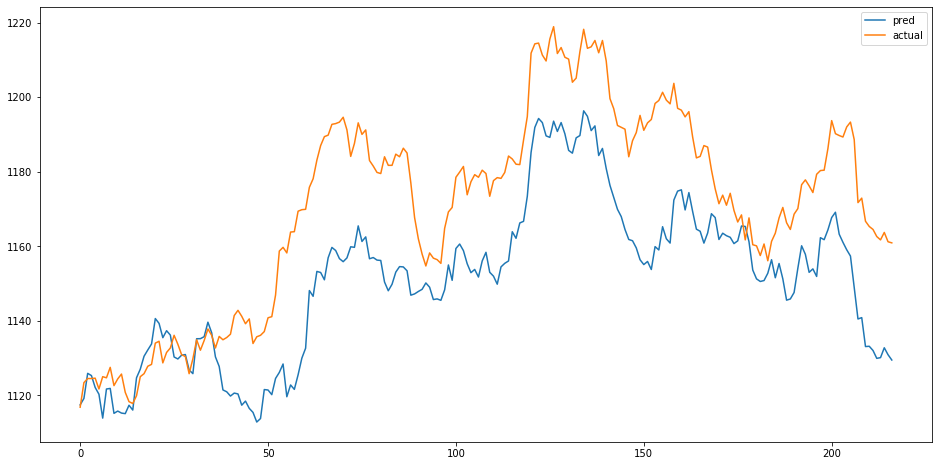

In [31]:
plt.figure(figsize=(16,8))
plt.plot(predicted, label='pred')
plt.plot(actual, label='actual')
plt.legend(loc='best')
plt.show()